**Table of contents**<a id='toc0_'></a>    
- [map](#toc1_)    
  - [absolute, relative coordinates](#toc1_1_)    
- [Background subtraction and peak fitting](#toc2_)    
- [$dI/dV$ line spectra](#toc3_)    
- [single spectra](#toc4_)    
- [processing topographic data](#toc5_)    
- [topography](#toc6_)    
- [Mapping the spectrum coordinates to the topography image](#toc7_)    
  - [trying line spectra](#toc7_1_)    
- [Implementing $I(z)$ spectra](#toc8_)    
  - [Iz map](#toc8_1_)    
  - [Iz single spectrum](#toc8_2_)    
- [Iz line spectrum](#toc9_)    
- [Implementing repetitions](#toc10_)    
- [Plotting spectrum positions](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../')
import rhkpy

import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
from scipy import ndimage

In [4]:
topo = rhkpy.rhkdata('topo_ABC_Graphite-Sample5_9K_2021_08_12_15_11_14_726.sm4')

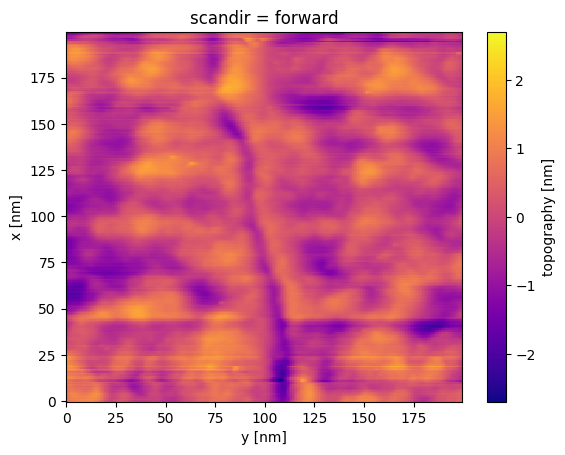

In [5]:
topo.image.sel(scandir = 'forward')['topography'].plot(cmap='plasma')

In [6]:
topo_data = topo.image.isel(scandir=1)['topography'].data

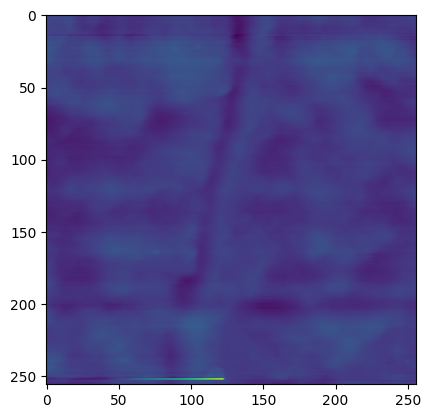

In [7]:
pl.imshow(topo_data)

# <a id='toc1_'></a>[map](#toc0_)

## <a id='toc1_1_'></a>[absolute, relative coordinates](#toc0_)

In [109]:
# 4x4 map
filename_map = 'hopg_300k_2020_08_11_16_04_06_999.sm4'
mapspec = rhkpy.rhkdata(filename_map)

rotation in the screenshot for map "...06_505":

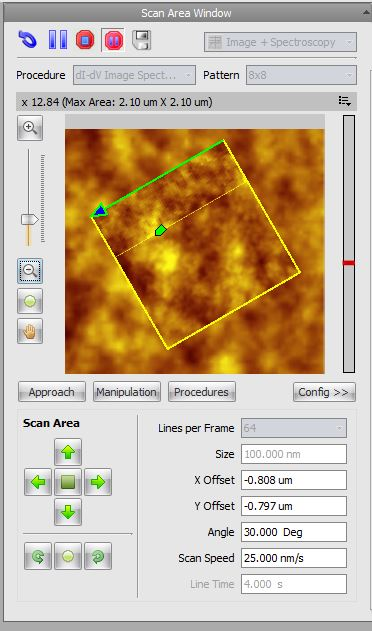

In [110]:
folder = r'C:\Users\zrbyt\OneDrive - energia.mta.hu\Documents\work_MFA\RHK Test Python Code\30 fok dIdV terkep' + '\\'
filename_map_30deg = 'MK_ABC_FLG_26_9K_2023_05_19_12_12_06_505.sm4'
map_30deg = rhkpy.rhkdata(folder + filename_map_30deg)

In [111]:
imagesize = np.max(map_30deg.image.x.data)
map_30deg.image.attrs['xoffset'] + imagesize/2, map_30deg.image.attrs['yoffset'] + imagesize/2

(-808.2508884399431, -797.4272762112378)

In [112]:
map_30deg.image['topography'][:, :, 0].hvplot(cmap = 'bone', aspect = 1)

:Image   [y,x]   (topography)

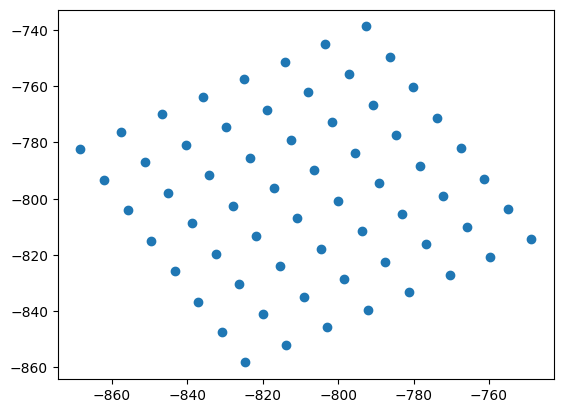

In [114]:
pl.scatter(map_30deg.spectra['x'].data, map_30deg.spectra['y'].data)

In [115]:
topofw_30deg = map_30deg.image['topography'].sel(scandir = 'forward')

In [116]:
map_30deg.image.attrs['scan angle']

30.0

In [117]:
rotated = ndimage.rotate(
		topofw_30deg.data,
		30,
		reshape = True,
		mode = 'constant',
		cval = 0
		)

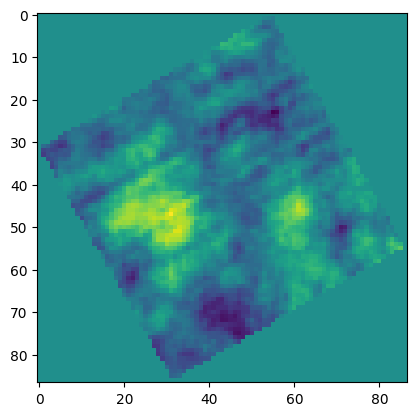

In [17]:
pl.imshow(rotated)

# <a id='toc2_'></a>[Background subtraction and peak fitting](#toc0_)

In [18]:
temp = map_30deg.spectra.sel(repetitions = 0, biasscandir = 'left')['lia'][:, 6, 3]
temp_map = map_30deg.spectra.sel(repetitions = 0, biasscandir = 'left')['lia']

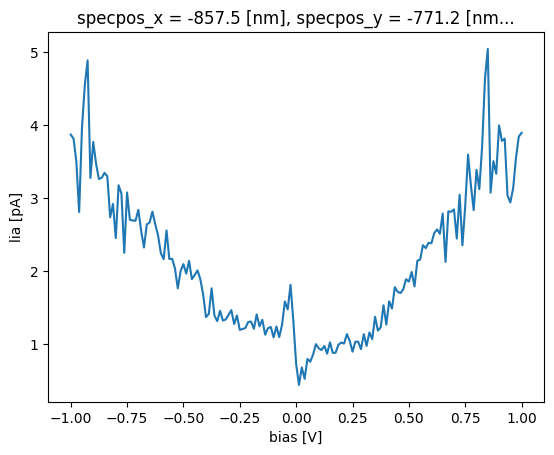

In [19]:
temp.plot()

Try to remove background

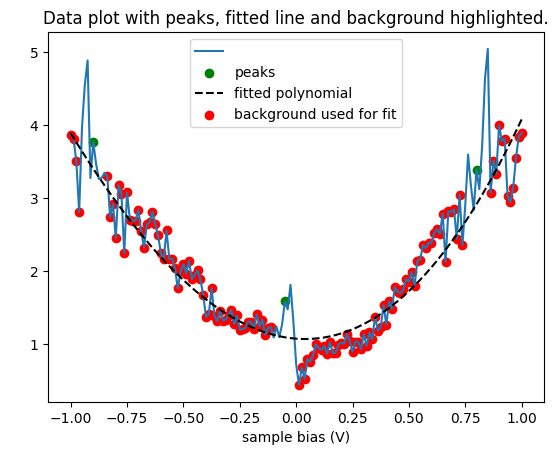

In [20]:
y_data_nobg, bg_values, coeff, params_used_at_run, mask, covar = rhkpy.bgsubtract(temp.bias.data, temp.data, toplot = True, peak_pos = [-0.9, -0.05, 0.8])

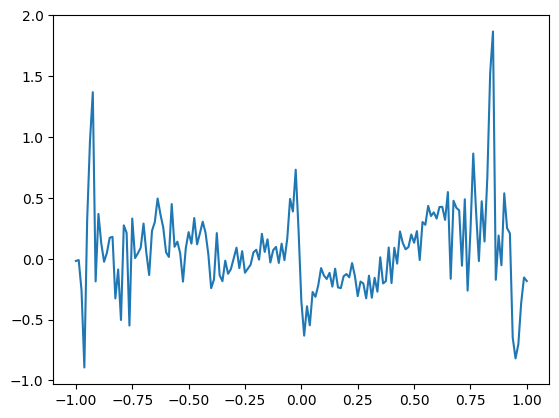

In [21]:
pl.plot(temp.bias.data, y_data_nobg)

In [22]:
temp2 = temp.copy()
temp2.data = y_data_nobg

In [23]:
starting_values = {'x0': -0.03, 'ampl': 0.8, 'width': 0.03}

Values of starting parameters: 
 {'x0': -0.03, 'ampl': 0.8, 'width': 0.03, 'offset': 0} 

Values of fitted parameters:

x0 : -0.04
ampl : 0.77
width : 0.03
offset : -0.14


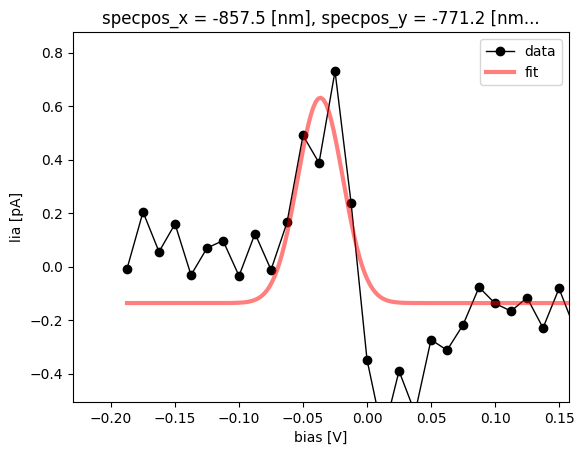

In [24]:
fit = rhkpy.peakfit(temp2.sel(bias = slice(0.2, -0.2)), stval = starting_values, toplot = True)

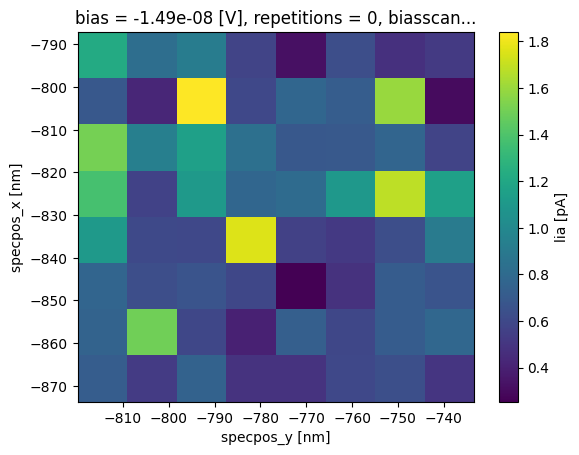

In [25]:
temp_map.sel(bias = 0, method='nearest').plot()

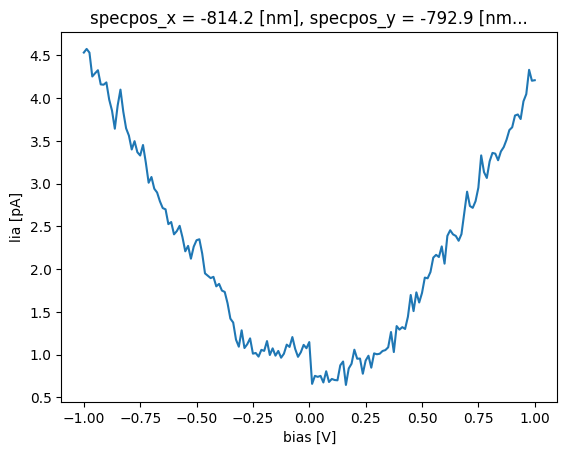

In [26]:
temp_map.sel(specpos_x = -813, specpos_y = -791, method = 'nearest').plot()

Values of starting parameters: 
 {'x0': -0.03, 'ampl': 0.8, 'width': 0.03, 'offset': 0} 

Values of fitted parameters:

x0 : -0.03
ampl : 1.25
width : 0.02
offset : 0.91


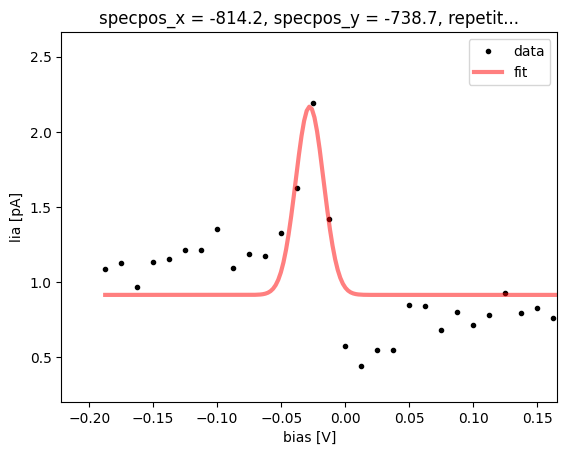

In [27]:
fitmap = rhkpy.peakfit(temp_map.sel(bias = slice(0.2, -0.2)), stval=starting_values, toplot=True, pos_x=-813, pos_y=-741)

In [90]:
rhkpy.conf_hvplot_defaults()

In [131]:
img = fitmap['curvefit_coefficients'].sel(param = 'width').hvplot.image(cmap = 'viridis')
hist = fitmap['curvefit_coefficients'].sel(param = 'width').hvplot.hist()

In [134]:
hist.opts(xlabel = 'peak width (V)', height = 250, width = 400) + img.opts(height = 150, title = 'peak width (V)')

:Layout
   .NdOverlay.I :NdOverlay   [Element]
      :Histogram   [curvefit_coefficients]   (curvefit_coefficients_count)
   .Image.I     :Image   [specpos_y,specpos_x]   (curvefit_coefficients)

# <a id='toc3_'></a>[$dI/dV$ line spectra](#toc0_)

In [118]:
filename_line = 'line_9K_ABC6_2020_11_01_12_12_27_213.sm4'
linespec = rhkpy.rhkdata(filename_line)

In [119]:
linespec.datatype, linespec.spectype

('line', 'iv')

In [120]:
linespec.spectra.attrs

{'filename': 'line_9K_ABC6_2020_11_01_12_12_27_213.sm4',
 'bias': 0.49999988,
 'bias units': 'V',
 'setpoint': 99.99999439624929,
 'setpoint units': 'pA',
 'measurement date': '11/01/20',
 'measurement time': '11:32:09',
 'scan angle': 168.75032,
 'LI amplitude': 10.0,
 'LI amplitude unit': 'mV',
 'LI frequency': 1300.0,
 'LI frequency unit': 'Hz',
 'LI phase': -102.9999998}

In [129]:
rhkpy.conf_hvplot_defaults()

In [130]:
linespec.spectra.isel(biasscandir = 0, repetitions = 0)['lia'].hvplot.image(cmap = 'viridis')

:Image   [dist,bias]   (lia)

# <a id='toc4_'></a>[single spectra](#toc0_)

In [8]:
filename_singlespec = 'dI-dV_Stripes-9K-HOPG-SPI2-3_2021_09_07_10_23_58_152.sm4'
spec = rhkpy(filename_singlespec)

In [9]:
spec.spectra.attrs

{'filename': 'dI-dV_Stripes-9K-HOPG-SPI2-3_2021_09_07_10_23_58_152.sm4',
 'speccoord_x': -97.14440096786348,
 'speccoord_y': -73.07891536356692,
 'speccoord_x units': 'nm',
 'speccoord_y units': 'nm',
 'bias': 0.59999996,
 'bias units': 'V',
 'setpoint': 39.999996370720936,
 'setpoint units': 'pA',
 'measurement date': '09/07/21',
 'measurement time': '10:19:42',
 'LI amplitude': 10.0,
 'LI amplitude unit': 'mV',
 'LI frequency': 1266.9999999999998,
 'LI frequency unit': 'Hz',
 'LI phase': -104.9999999}

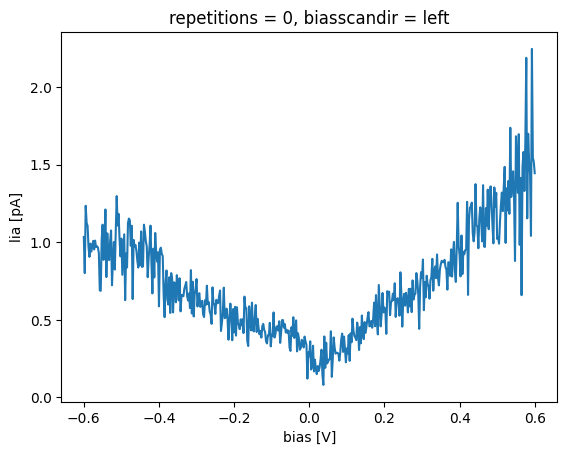

In [12]:
spec.spectra.isel(repetitions = 0, biasscandir = 0)['lia'].plot(label = 'first spectrum')

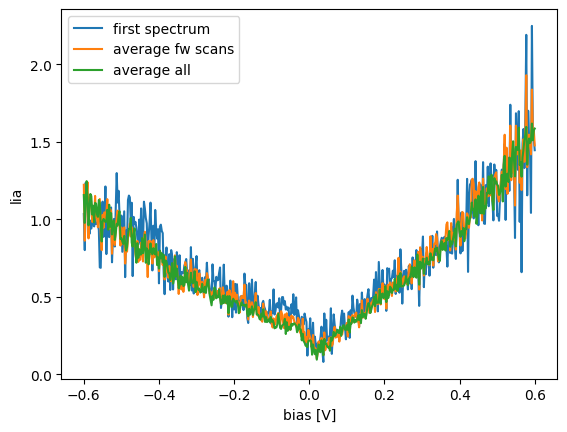

In [13]:
spec.spectra.isel(repetitions = 0, biasscandir = 0)['lia'].plot(label = 'first spectrum')
spec.spectra.isel(biasscandir = 0).mean(dim='repetitions')['lia'].plot(label = 'average fw scans')
spec.spectra.mean(dim=['repetitions', 'biasscandir'])['lia'].plot(label = 'average all')
pl.legend()

# <a id='toc5_'></a>[processing topographic data](#toc0_)

In [14]:
from spym.process.level import align
from spym.process.level import plane

In [10]:
filename_map_large = 'C:/Users/zrbyt/OneDrive - energia.mta.hu/Documents/work_MFA/cikkek - published/2022/RG magnetism/figures/splitting/9K_ABC6_2020_11_02_08_47_19_209.sm4'
mapspec = rhkpy(filename_map_large)

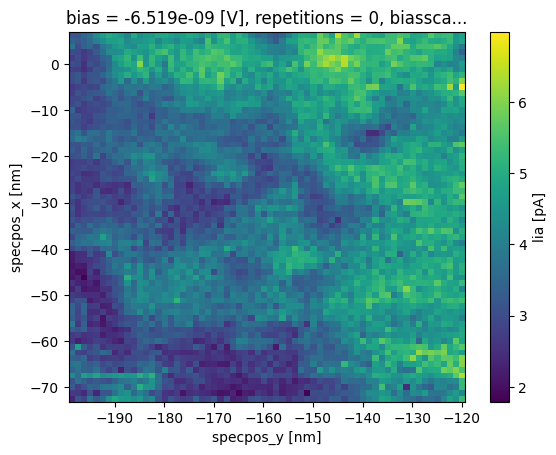

In [11]:
mapspec.spectra.isel(biasscandir = 0, repetitions = 0).sel(bias = 0, method='nearest')['lia'].plot()

# <a id='toc6_'></a>[topography](#toc0_)

In [17]:
topo = rhkpy.stmdata('topo_ABC_Graphite-Sample5_9K_2021_08_12_15_11_14_726.sm4')

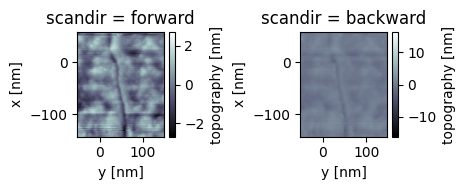

In [18]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize = (4.7, 2))
topo.image.isel(scandir = 0)['topography'].plot(cmap = 'bone', ax = ax1)
topo.image.isel(scandir = 1)['topography'].plot(cmap = 'bone', ax = ax2)
pl.tight_layout()

In [19]:
topo.image.attrs

{'filename': 'topo_ABC_Graphite-Sample5_9K_2021_08_12_15_11_14_726.sm4',
 'xoffset': -142.51390409447674,
 'yoffset': -51.648785998059665,
 'xoffset_units': 'nm',
 'yoffset_units': 'nm',
 'bias': 0.49999982,
 'bias units': 'V',
 'setpoint': 99.99999439624929,
 'setpoint units': 'pA',
 'measurement date': '08/12/21',
 'measurement time': '15:01:33'}

# <a id='toc7_'></a>[Mapping the spectrum coordinates to the topography image](#toc0_)

In [12]:
mapspec = rhkpy(filename_map)

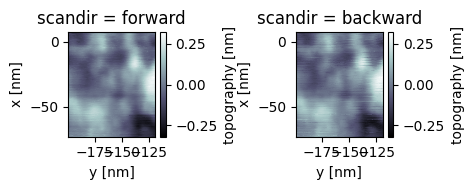

In [21]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize = (4.7, 2))
mapspec.image.isel(scandir = 0)['topography'].plot(cmap = 'bone', ax = ax1)
mapspec.image.isel(scandir = 1)['topography'].plot(cmap = 'bone', ax = ax2)
pl.tight_layout()

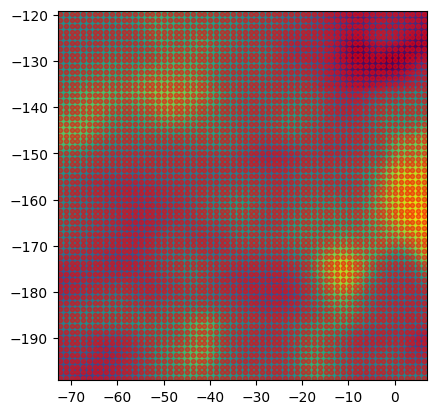

In [22]:
xx = mapspec.image.coords['x'].data
yy = mapspec.image.coords['y'].data
dx = (xx[1] - xx[0])/2.
dy = (yy[1] - yy[0])/2.
ext = [xx[0] - dx, xx[-1] + dx, yy[0] - dy, yy[-1] + dy]
pl.imshow(mapspec.image.isel(scandir = 0)['topography'].data,
         extent = ext)
pl.scatter(mapspec.spectra['x'].data, mapspec.spectra['y'].data, marker = '.', alpha = 0.5, color = 'r')

In [23]:
mapspec.spymdata.Topography_Forward.attrs['RHK_Angle']

0.0

## <a id='toc7_1_'></a>[trying line spectra](#toc0_)

In [13]:
linespec = rhkpy(filename_line)

In [25]:
linespec.spymdata.Topography_Forward.attrs['RHK_Angle']

168.75032

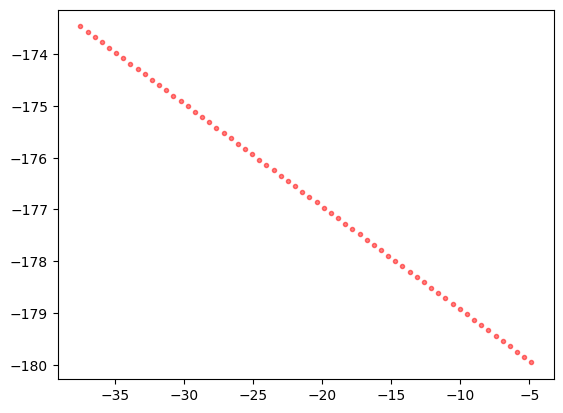

In [26]:
pl.scatter(linespec.spectra['x'].data, linespec.spectra['y'].data, marker = '.', alpha = 0.5, color = 'r')

# <a id='toc8_'></a>[Implementing $I(z)$ spectra](#toc0_)

## <a id='toc8_1_'></a>[Iz map](#toc0_)

In [16]:
filename_izmap = 'Iz_map_Stripes-9K-HOPG-SPI2-3_2021_09_08_11_21_03_743.sm4'
izmap = rhkpy.rhkdata(filename_izmap, repetitions = 10)

In [17]:
izmapspym = rhkpy.load_spym(filename_izmap)

In [18]:
print(izmap.datatype, izmap.spectype)

map iz


In [19]:
izmap.image.attrs

{'filename': 'Iz_map_Stripes-9K-HOPG-SPI2-3_2021_09_08_11_21_03_743.sm4',
 'xoffset': -115.0443512398791,
 'yoffset': -89.23446900843679,
 'xoffset_units': 'nm',
 'yoffset_units': 'nm',
 'bias': 1.0,
 'bias units': 'V',
 'setpoint': 79.99999968033578,
 'setpoint units': 'pA',
 'measurement date': '09/08/21',
 'measurement time': '09:38:39',
 'scan angle': -10.0}

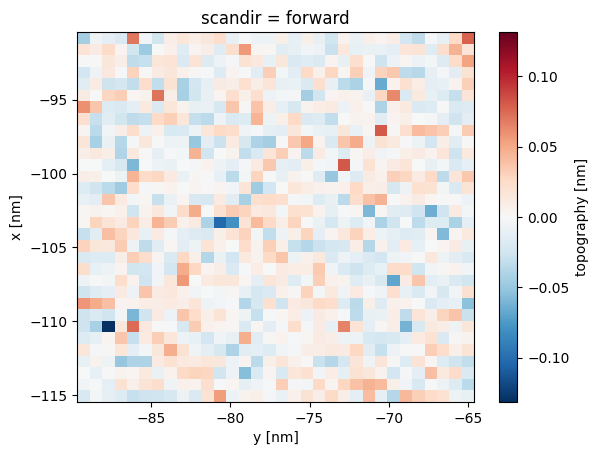

In [20]:
izmap.image.isel(scandir = 0)['topography'].plot()

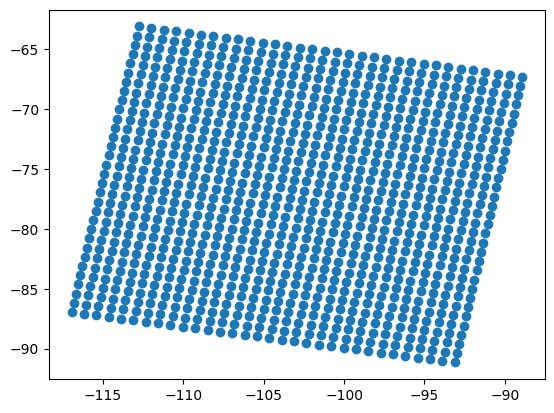

In [22]:
pl.scatter(izmap.spectra['x'].data, izmap.spectra['y'].data)

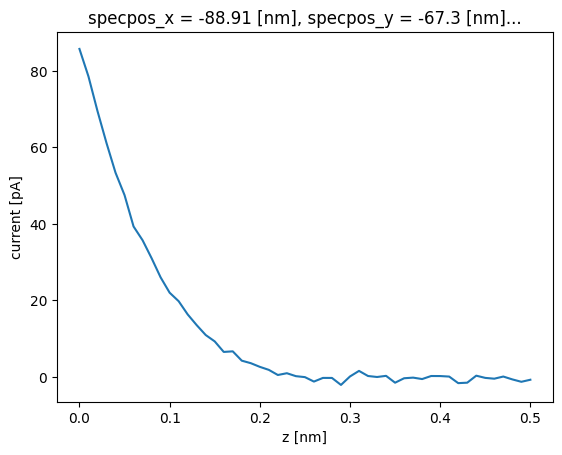

In [32]:
izmap.spectra.isel(zscandir = 0, repetitions = 0, specpos_x = 0, specpos_y = 0)['current'].plot()

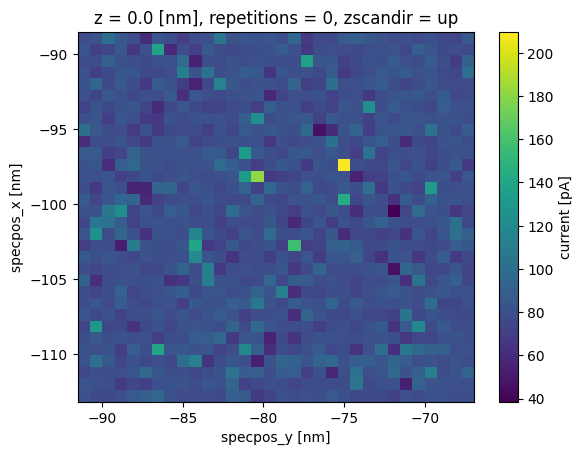

In [18]:
izmap.spectra.isel(zscandir = 0, repetitions = 0).sel(z = 0, method='nearest')['current'].plot()

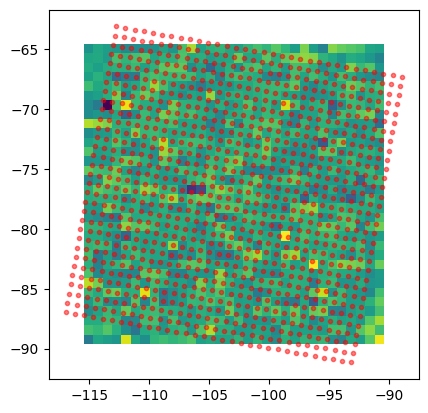

In [34]:
xx = izmap.image.coords['x'].data
yy = izmap.image.coords['y'].data
dx = (xx[1] - xx[0])/2.
dy = (yy[1] - yy[0])/2.
ext = [xx[0] - dx, xx[-1] + dx, yy[0] - dy, yy[-1] + dy]
pl.imshow(izmap.image.isel(scandir = 0)['topography'].data,
         extent = ext)
pl.scatter(izmap.spectra['x'].data, izmap.spectra['y'].data, marker = '.', alpha = 0.5, color = 'r')

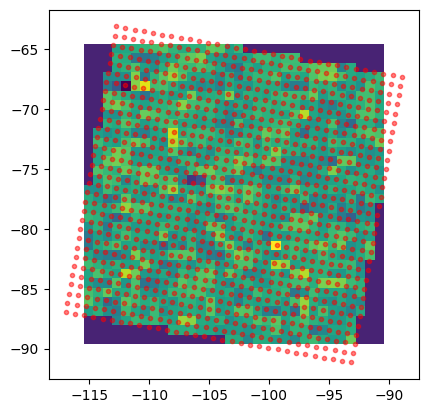

In [35]:
from scipy import ndimage

xx = izmap.image.coords['x'].data
yy = izmap.image.coords['y'].data
dx = (xx[1] - xx[0])/2.
dy = (yy[1] - yy[0])/2.
ext = [xx[0] - dx, xx[-1] + dx, yy[0] - dy, yy[-1] + dy]

angle = izmap.spymdata.Topography_Forward.attrs['RHK_Angle']
rotated_topo = ndimage.rotate(
    izmap.image.isel(scandir = 0)['topography'].data,
    angle,
    reshape=False,
    mode='constant',
    cval=-0.1
)
pl.imshow(rotated_topo, extent = ext)
pl.scatter(izmap.spectra['x'].data, izmap.spectra['y'].data, marker = '.', alpha = 0.5, color = 'r')

In [36]:
izmap.spymdata.Topography_Forward.attrs['RHK_Angle']

-10.0

## <a id='toc8_2_'></a>[Iz single spectrum](#toc0_)

In [37]:
filename_izspec = 'Iz_Stripes-9K-HOPG-SPI2-3_2021_09_07_10_15_28_529.sm4'
izspec = rhkpy.stmdata(filename_izspec)

In [38]:
print(izspec.datatype, izspec.spectype, izspec.numberofspectra, izspec.repetitions)

spec iz 20 10


In [39]:
izspec.spectra.attrs

{'filename': 'Iz_Stripes-9K-HOPG-SPI2-3_2021_09_07_10_15_28_529.sm4',
 'speccoord_x': -97.14440096786348,
 'speccoord_y': -73.07891536356692,
 'speccoord_x units': 'nm',
 'speccoord_y units': 'nm',
 'bias': 0.6,
 'bias units': 'V',
 'setpoint': 39.99999984016789,
 'setpoint units': 'pA',
 'measurement date': '09/07/21',
 'measurement time': '10:15:22'}

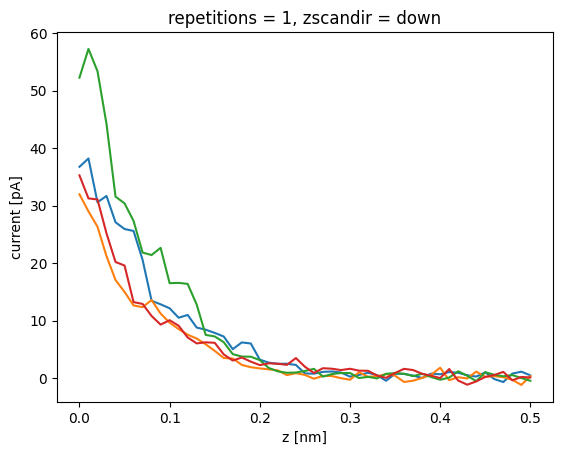

In [40]:
izspec.spectra.isel(zscandir = 0, repetitions = 0)['current'].plot()
izspec.spectra.isel(zscandir = 1, repetitions = 0)['current'].plot()
izspec.spectra.isel(zscandir = 0, repetitions = 1)['current'].plot()
izspec.spectra.isel(zscandir = 1, repetitions = 1)['current'].plot()

# <a id='toc9_'></a>[Iz line spectrum](#toc0_)

In [53]:
izlinespec = rhkpy(filename_izline)

In [54]:
izlinespec.repetitions

10

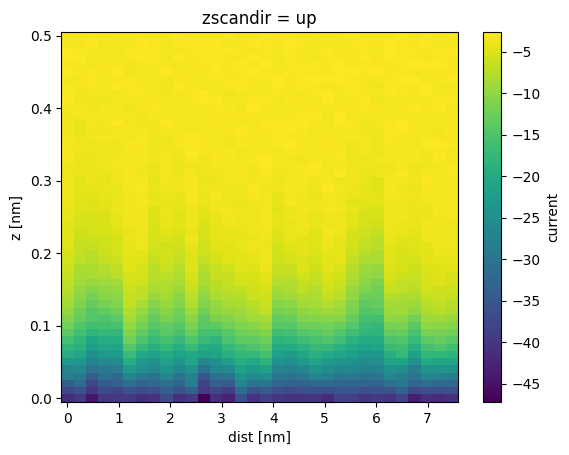

In [55]:
izlinespec.spectra.isel(zscandir=0).mean(dim='repetitions')['current'].plot()

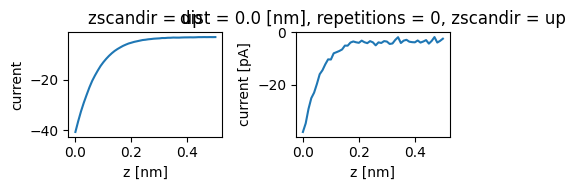

In [56]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize = (4.7, 2))
izlinespec.spectra.isel(zscandir=0).mean(dim=['repetitions', 'dist'])['current'].plot(ax=ax1)
izlinespec.spectra.isel(zscandir=0, repetitions=0, dist=0)['current'].plot(ax=ax2)
pl.tight_layout()

# <a id='toc10_'></a>[Implementing repetitions](#toc0_)

In [50]:
filename_izmap = 'Iz_map_Stripes-9K-HOPG-SPI2-3_2021_09_08_11_21_03_743.sm4'
izmap = rhkpy(filename_izmap)

In [51]:
izmap.repetitions

10

In [21]:
filename_map_large = 'C:/Users/zrbyt/OneDrive - energia.mta.hu/Documents/work_MFA/cikkek - published/2022/RG magnetism/figures/splitting/9K_ABC6_2020_11_02_08_47_19_209.sm4'
mapspec = rhkpy(filename_map_large)

In [22]:
mapspec.repetitions

1

In [23]:
mapspec.numberofspectra

2

In [24]:
mapspec.spymdata.Topography_Forward.attrs['RHK_ScanType'], mapspec.spymdata.Topography_Forward.attrs['RHK_ScanTypeName']

(0, 'RHK_SCAN_RIGHT')

# <a id='toc11_'></a>[Plotting spectrum positions](#toc0_)

In [3]:
filename_izmap = 'Iz_map_Stripes-9K-HOPG-SPI2-3_2021_09_08_11_21_03_743.sm4'
izmap = rhkpy(filename_izmap)

In [4]:
izmap.spectra

<xarray.Dataset>
Dimensions:      (z: 51, specpos_x: 32, specpos_y: 32, repetitions: 10,
                  zscandir: 2)
Coordinates:
  * z            (z) float64 0.0 0.01 0.02 0.03 0.04 ... 0.46 0.47 0.48 0.49 0.5
  * specpos_x    (specpos_x) float64 -88.91 -89.68 -90.45 ... -112.0 -112.8
  * specpos_y    (specpos_y) float64 -67.3 -68.07 -68.84 ... -90.38 -91.15
  * repetitions  (repetitions) int32 0 1 2 3 4 5 6 7 8 9
  * zscandir     (zscandir) <U4 'up' 'down'
Data variables:
    current      (z, specpos_x, specpos_y, repetitions, zscandir) float64 85....
    x            (specpos_x, specpos_y) float64 -88.91 -89.68 ... -116.2 -117.0
    y            (specpos_x, specpos_y) float64 -67.3 -67.17 ... -87.08 -86.95
Attributes: (12/13)
    filename:           Iz_map_Stripes-9K-HOPG-SPI2-3_2021_09_08_11_21_03_743...
    bias:               1.0
    bias units:         V
    setpoint:           79.99999968033578
    setpoint units:     pA
    measurement date:   09/08/21
    ...                 ...
    scan angle:         -10.0
    LI amplitude:       10.0
    LI amplitude unit:  mV
    LI frequency:       1266.9999999999998
    LI frequency unit:  Hz
    LI phase:           -104.9999999

In [5]:
topo = izmap.image.isel(scandir=0)

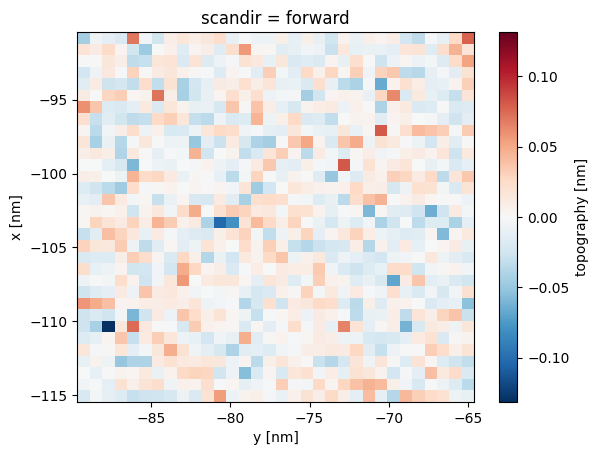

In [17]:
topo['topography'].plot()

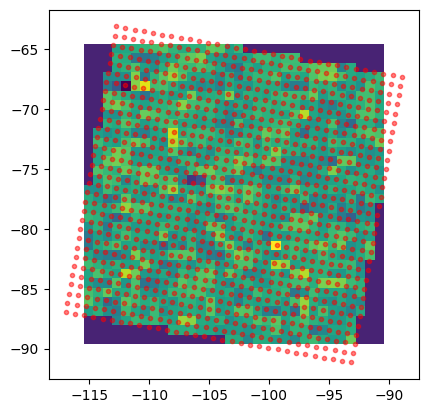

In [6]:
izmap.specpos()

In [7]:
izmap.image.attrs['scan angle']

-10.0

In [4]:
# import hvplot as hv
import hvplot.xarray

In [5]:
hvplot.extension('bokeh')

In [7]:
izmap.spectra.mean(dim=['repetitions', 'zscandir']).hvplot.line(
    x='z',
    y='current',
    # aspect=1,
    height=300, width=350)

:DynamicMap   [specpos_y,specpos_x]
   :Curve   [z]   (current)

In [135]:
iz1 = izmap.spectra.mean(dim=['repetitions', 'zscandir']).sel(specpos_x = -91, specpos_y = -112, method='nearest').hvplot.line(
    x='z',
    y='current',
    # aspect=1,
    height=300, width=350)
iz2 = izmap.spectra.mean(dim=['repetitions', 'zscandir']).sel(specpos_x = -89, specpos_y = -112, method='nearest').hvplot.line(
    x='z',
    y='current',
    # aspect=1,
    height=300, width=350)

In [136]:
iz1 * iz2

:Overlay
   .Curve.I  :Curve   [z]   (current)
   .Curve.II :Curve   [z]   (current)

In [137]:
iz1 + iz2

:Layout
   .Curve.I  :Curve   [z]   (current)
   .Curve.II :Curve   [z]   (current)

In [138]:
izplot = izmap.spectra.mean(dim=['repetitions', 'zscandir']).hvplot.line(
    x='z',
    y='current',
    # aspect=1,
    height=300, width=350,
    groupby=['specpos_x', 'specpos_y'])

In [139]:
print(izplot)

:DynamicMap   [specpos_x,specpos_y]


In [140]:
izplot

:DynamicMap   [specpos_x,specpos_y]
   :Curve   [z]   (current)

In [141]:
z = izmap.spectra.mean(dim=['repetitions', 'zscandir'])['current'].isel(specpos_x=0, specpos_y=0).hvplot.line(x='z', aspect=1)

In [142]:
print(z)

:Curve   [z]   (current)


In [11]:
izmap.spectra.mean(dim=['repetitions', 'zscandir']).hvplot.scatter(
    marker='o',
    x='z',
    y='current',
    # aspect=1,
    height=300, width=350)

:DynamicMap   [specpos_y,specpos_x]
   :Scatter   [z]   (current)

In [20]:
xx = izmap.spectra.coords['specpos_x'].data
yy = izmap.spectra.coords['specpos_y'].data

izcurves = izmap.spectra.mean(dim=['repetitions'])['current']

curve = izcurves.sel(specpos_x=xx[0], specpos_y=yy[0]).hvplot.line(
    aspect=1,
    color='r',
    alpha=0.1,
    groupby='zscandir'
)
for x in xx[1:10]:
    for y in yy[1:10]:
        curve = curve * izcurves.sel(specpos_x=x, specpos_y=y).hvplot.scatter(
            marker='o',
            aspect=1,
            color='r',
            alpha=0.02,
            groupby='zscandir'
        )

In [21]:
curve

:DynamicMap   [zscandir]
   :Overlay
      .Curve.I         :Curve   [z]   (current)
      .Scatter.I       :Scatter   [z]   (current)
      .Scatter.II      :Scatter   [z]   (current)
      .Scatter.III     :Scatter   [z]   (current)
      .Scatter.IV      :Scatter   [z]   (current)
      .Scatter.V       :Scatter   [z]   (current)
      .Scatter.VI      :Scatter   [z]   (current)
      .Scatter.VII     :Scatter   [z]   (current)
      .Scatter.VIII    :Scatter   [z]   (current)
      .Scatter.IX      :Scatter   [z]   (current)
      .Scatter.X       :Scatter   [z]   (current)
      .Scatter.XI      :Scatter   [z]   (current)
      .Scatter.XII     :Scatter   [z]   (current)
      .Scatter.XIII    :Scatter   [z]   (current)
      .Scatter.XIV     :Scatter   [z]   (current)
      .Scatter.XV      :Scatter   [z]   (current)
      .Scatter.XVI     :Scatter   [z]   (current)
      .Scatter.XVII    :Scatter   [z]   (current)
      .Scatter.XVIII   :Scatter   [z]   (current)
      .Scatter.XIX     :Scatter   [z]   (current)
      .Scatter.XX      :Scatter   [z]   (current)
      .Scatter.XXI     :Scatter   [z]   (current)
      .Scatter.XXII    :Scatter   [z]   (current)
      .Scatter.XXIII   :Scatter   [z]   (current)
      .Scatter.XXIV    :Scatter   [z]   (current)
      .Scatter.XXV     :Scatter   [z]   (current)
      .Scatter.XXVI    :Scatter   [z]   (current)
      .Scatter.XXVII   :Scatter   [z]   (current)
      .Scatter.XXVIII  :Scatter   [z]   (current)
      .Scatter.XXIX    :Scatter   [z]   (current)
      .Scatter.XXX     :Scatter   [z]   (current)
      .Scatter.XXXI    :Scatter   [z]   (current)
      .Scatter.XXXII   :Scatter   [z]   (current)
      .Scatter.XXXIII  :Scatter   [z]   (current)
      .Scatter.XXXIV   :Scatter   [z]   (current)
      .Scatter.XXXV    :Scatter   [z]   (current)
      .Scatter.XXXVI   :Scatter   [z]   (current)
      .Scatter.XXXVII  :Scatter   [z]   (current)
      .Scatter.XXXVIII :Scatter   [z]   (current)
      .Scatter.XXXIX   :Scatter   [z]   (current)
      .Scatter.XL      :Scatter   [z]   (current)
      .Scatter.XLI     :Scatter   [z]   (current)
      .Scatter.XLII    :Scatter   [z]   (current)
      .Scatter.XLIII   :Scatter   [z]   (current)
      .Scatter.XLIV    :Scatter   [z]   (current)
      .Scatter.XLV     :Scatter   [z]   (current)
      .Scatter.XLVI    :Scatter   [z]   (current)
      .Scatter.XLVII   :Scatter   [z]   (current)
      .Scatter.XLVIII  :Scatter   [z]   (current)
      .Scatter.XLIX    :Scatter   [z]   (current)
      .Scatter.L       :Scatter   [z]   (current)
      .Scatter.LI      :Scatter   [z]   (current)
      .Scatter.LII     :Scatter   [z]   (current)
      .Scatter.LIII    :Scatter   [z]   (current)
      .Scatter.LIV     :Scatter   [z]   (current)
      .Scatter.LV      :Scatter   [z]   (current)
      .Scatter.LVI     :Scatter   [z]   (current)
      .Scatter.LVII    :Scatter   [z]   (current)
      .Scatter.LVIII   :Scatter   [z]   (current)
      .Scatter.LIX     :Scatter   [z]   (current)
      .Scatter.LX      :Scatter   [z]   (current)
      .Scatter.LXI     :Scatter   [z]   (current)
      .Scatter.LXII    :Scatter   [z]   (current)
      .Scatter.LXIII   :Scatter   [z]   (current)
      .Scatter.LXIV    :Scatter   [z]   (current)
      .Scatter.LXV     :Scatter   [z]   (current)
      .Scatter.LXVI    :Scatter   [z]   (current)
      .Scatter.LXVII   :Scatter   [z]   (current)
      .Scatter.LXVIII  :Scatter   [z]   (current)
      .Scatter.LXIX    :Scatter   [z]   (current)
      .Scatter.LXX     :Scatter   [z]   (current)
      .Scatter.LXXI    :Scatter   [z]   (current)
      .Scatter.LXXII   :Scatter   [z]   (current)
      .Scatter.LXXIII  :Scatter   [z]   (current)
      .Scatter.LXXIV   :Scatter   [z]   (current)
      .Scatter.LXXV    :Scatter   [z]   (current)
      .Scatter.LXXVI   :Scatter   [z]   (current)
      .Scatter.LXXVII  :Scatter   [z]   (current)
      .Scatter.LXXVIII :Scatter   [z]   (current)
      .Scatter.